# Verification History

In [1]:
import json, re, pprint, os
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('pgf') # this makes exports more beautiful, but disables plots in this notebook

DIRECTORY = "."

pltsettings = {
    "figure.figsize" : (5.0, 4.0),
    "pgf.texsystem" : "pdflatex",
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    #"font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pltsettings)

import matplotlib.pyplot as plt
#import seaborn as sns # makes exports ugly

In [2]:
def read_json(fname):
    """
    reads JSOn and returns (totals, units), tuple of dicts
    """
    units=None
    totals=None
    with open(fname,'r') as f:
        endofunits = False
        for line in f:
            match = re.search(r'^TOTALS', line)        
            if match:                
                endofunits = True
            if not endofunits:
                try:
                    if not units:
                        units = json.loads(line)
                    else:
                        print "error: units appearing multiple times"
                except:
                    pass
            else:
                try:
                    if not totals:
                        totals = json.loads(line)
                    else:
                        print "error: totals appearing multiple times"
                except:
                    pass
    # unpack units (list of dicts) => dict
    if units:
        tmp=units
        units={}
        for u in tmp:
            name=u.keys()[0]
            stats=u[name]
            #print "unit="+name +", stats=" + str(stats)
            units[name]=stats       
    return (totals, units)
              
#######
from datetime import datetime
def date_from_path(f):
    """
    Extract calendar date from file path. If fails, take 
    folder name
    """
    parts = f.split(os.sep)
    for p in parts:
        match = re.search(r"(\d+-\d+-\d+_\d+:\d+:\d+)", p)
        if match:            
            try:            
                dobj = datetime.strptime(match.group(1), "%Y-%m-%d_%H:%M:%S")
                return dobj
            except:                
                pass            
    return parts[0]
#######
import fnmatch

# find all log files in the subfolders
logfiles=[]
for root, dirnames, filenames in os.walk(DIRECTORY):
    for f in fnmatch.filter(filenames, 'unitstats*.log'):
        logfiles.append(os.path.join(root, f))                    
                
# load each of them into dict calendar date -> data
logfiles=list(set(logfiles))

alldata = {}
for f in logfiles:
    if True: #try:
        caldate = date_from_path (f)
        (totals, units) = read_json(f)
        print "file=" + f + ", date=" + str(caldate)
        if not caldate in alldata:
            alldata[caldate] = {}
        alldata[caldate]["totals"] = totals
        #alldata[caldate]["units"] = units
    else: #except:
        pass    
    
print "FIRST: "
t = alldata.keys()[0]
print str(t) + ": "+ str(alldata[t]["totals"])


file=./2016-07-26_00:34:58_+0200/gnatprove_1/unitstats.log, date=2016-07-26 00:34:58
file=./2017-02-02_19:43:52_+0100/gnatprove_1/unitstats.log, date=2017-02-02 19:43:52
file=./2017-01-21_18:47:19_+0100/gnatprove_1/unitstats.log, date=2017-01-21 18:47:19
file=./2016-07-27_15:19:10_+0200/gnatprove_1/unitstats.log, date=2016-07-27 15:19:10
file=./2017-01-24_19:41:21_+0100/gnatprove_1/unitstats.log, date=2017-01-24 19:41:21
file=./2017-01-24_23:21:20_+0100/gnatprove_1/unitstats.log, date=2017-01-24 23:21:20
file=./2016-09-06_19:10:45_+0200/gnatprove_1/unitstats.log, date=2016-09-06 19:10:45
file=./2016-08-11_17:22:06_+0200/gnatprove_1/unitstats.log, date=2016-08-11 17:22:06
file=./2017-01-21_00:52:08_+0100/gnatprove_1/unitstats.log, date=2017-01-21 00:52:08
file=./2016-08-14_15:59:16_+0200/gnatprove_1/unitstats.log, date=2016-08-14 15:59:16
file=./2016-08-12_12:06:25_+0200/gnatprove_1/unitstats.log, date=2016-08-12 12:06:25
file=./2016-07-30_14:47:07_+0200/gnatprove_1/unitstats.log, date=

## Now make graph over totals

/home/becker/bin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


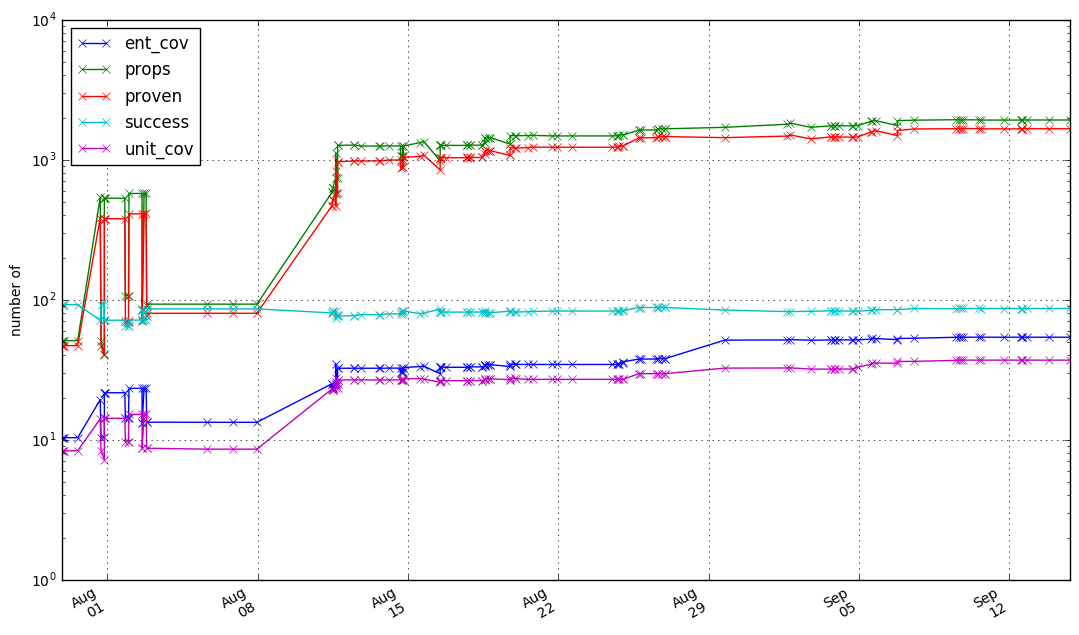

In [3]:
import matplotlib.dates as dates
totals = {k : v['totals'] for k,v in alldata.iteritems() if v['totals']['props'] > 0}

# test data:
#totals={datetime(2016, 10, 12, 14, 57, 31): {'props' : 10, 'proven': 9},datetime(2016, 10, 13, 14, 57, 31): {'props' : 11, 'proven': 9},datetime(2016, 10, 14, 14, 57, 31): {'props' : 11, 'proven': 10},datetime(2016, 10, 15, 14, 57, 31): {'props' : 10, 'proven': 10}}

df = pd.DataFrame(totals).T;
#print df.head()

exclude_columns=['units','ents', 'flows','skip','flows_proven', 'suppressed', 'flows_suppressed', 'flows_success']
ax=df.ix[ : "2016-09-15",df.columns.difference(exclude_columns)].plot(logy=True, marker='x',figsize=(13,8));
#ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1), interval=1))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.set_major_locator(dates.MonthLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b\n%d'))
ax.xaxis.grid(True, which="major")
ax.xaxis.grid(False, which="minor")
ax.set_ylabel('number of')
ax.yaxis.grid()
plt.savefig(DIRECTORY + os.sep + 'history.pdf', bbox_inches='tight')
plt.show()